In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('deforestation_dataset.csv')

# Inspect for missing values and anomalies
print(df.info())
print(df.describe())
print(df.isnull().sum())
print(df.head())

# Data Cleaning: Handle missing values
# For simplicity, drop rows with missing values (can be replaced with imputation if needed)
df_cleaned = df.dropna()

# Convert categorical columns to numerical values
categorical_cols = ['Deforestation_Policy_Strictness', 'Corruption_Index']
df_encoded = pd.get_dummies(df_cleaned, columns=categorical_cols)

# Display cleaned and encoded data
print(df_encoded.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          100 non-null    object 
 1   Year                             100 non-null    int64  
 2   Forest_Loss_Area_km2             100 non-null    int64  
 3   Tree_Cover_Loss_percent          100 non-null    float64
 4   CO2_Emission_mt                  100 non-null    int64  
 5   Rainfall_mm                      100 non-null    float64
 6   Population                       100 non-null    int64  
 7   GDP_Billion_USD                  100 non-null    float64
 8   Agriculture_Land_Percent         100 non-null    float64
 9   Deforestation_Policy_Strictness  100 non-null    int64  
 10  Corruption_Index                 100 non-null    float64
 11  International_Aid_Million_USD    100 non-null    int64  
 12  Illegal_Lumbering_Incid

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif

# Select numerical columns for scaling (excluding target and categorical columns)
numerical_cols = [
    'Year', 'Forest_Loss_Area_km2', 'Tree_Cover_Loss_percent', 'CO2_Emission_mt',
    'Rainfall_mm', 'Population', 'GDP_Billion_USD', 'Agriculture_Land_Percent',
    'International_Aid_Million_USD', 'Illegal_Lumbering_Incidents', 'Protected_Areas_Percent'
]

# Standardize numerical features
scaler = StandardScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

# Example: Feature selection (top 10 features)
# Assume target variable is 'Forest_Loss_Area_km2' (replace with actual target if different)
X = df_encoded.drop(columns=['Forest_Loss_Area_km2', 'Country'])
y = df_encoded['Forest_Loss_Area_km2']

selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("Top 10 selected features:", selected_features.tolist())

Top 10 selected features: ['Corruption_Index_92.56887950673188', 'Corruption_Index_92.6838455570416', 'Corruption_Index_93.88520297586756', 'Corruption_Index_96.12875003604482', 'Corruption_Index_96.49946329942216', 'Corruption_Index_96.58885181054592', 'Corruption_Index_96.86692495954988', 'Corruption_Index_97.7844576892694', 'Corruption_Index_98.37720193826966', 'Corruption_Index_99.49228375628628']


C:\Users\user\AppData\Roaming\Python\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


In [4]:
from sklearn.model_selection import train_test_split

# Split X_new and y into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42, shuffle=True)

In [6]:
from sklearn.svm import SVR

# Train SVR model with linear kernel to predict Forest_Loss_Area_km2
svm_model = SVR(kernel='linear')
svm_model.fit(X_train, y_train)

# Evaluate performance on training data using R^2 score
train_score = svm_model.score(X_train, y_train)
print(f"SVR Training R^2 Score (Forest_Loss_Area_km2, linear kernel): {train_score:.4f}")

SVR Training R^2 Score (Forest_Loss_Area_km2, linear kernel): 0.0586


Test MAE: 0.8014
Test MSE: 0.8878
Test RMSE: 0.9422
Test R^2 Score: -0.3666


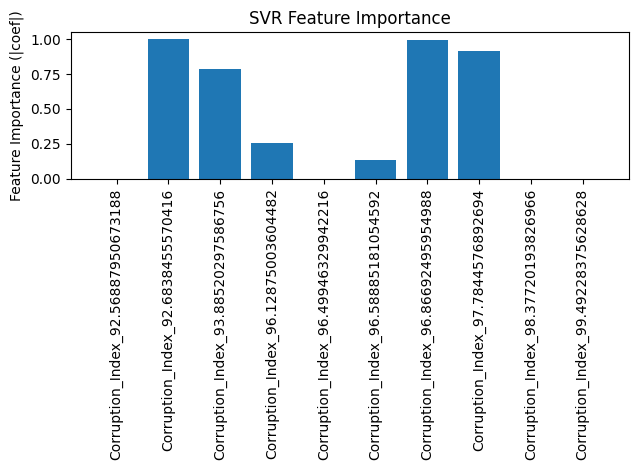

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

import matplotlib.pyplot as plt

# Predict on test set
y_pred = svm_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Test MAE: {mae:.4f}")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R^2 Score: {r2:.4f}")

# Feature importance (absolute value of coefficients)
feature_importance = np.abs(svm_model.coef_[0])
plt.bar(range(len(selected_features)), feature_importance)
plt.xticks(range(len(selected_features)), selected_features, rotation=90)
plt.ylabel("Feature Importance (|coef|)")
plt.title("SVR Feature Importance")
plt.tight_layout()
plt.show()

In [8]:
from sklearn.model_selection import GridSearchCV, cross_val_score

# Define parameter grid for SVR
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]  # Only used for 'poly' kernel
}

# Create SVR model
svr = SVR()

# GridSearchCV for hyperparameter tuning with 5-fold cross-validation
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validated R^2 score:", grid_search.best_score_)

# Evaluate best model on test set
best_svr = grid_search.best_estimator_
test_r2 = best_svr.score(X_test, y_test)
print("Test R^2 score (best model):", test_r2)

# Cross-validation scores for robustness
cv_scores = cross_val_score(best_svr, X_train, y_train, cv=5, scoring='r2')
print("Cross-validation R^2 scores:", cv_scores)
print("Mean CV R^2 score:", cv_scores.mean())

Best parameters: {'C': 100, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
Best cross-validated R^2 score: -0.07972014374747353
Test R^2 score (best model): -0.3673090009139479
Cross-validation R^2 scores: [-0.00098362 -0.17788159 -0.02372685 -0.15279552 -0.04321314]
Mean CV R^2 score: -0.07972014374747353


In [9]:
# Generate a feature importance report based on SVR coefficients and selected features

# Map selected_features to their corresponding importance values
feature_importance_report = []
for feature, importance in zip(selected_features, feature_importance):
    feature_importance_report.append((feature, importance))

# Sort features by importance (descending)
feature_importance_report.sort(key=lambda x: x[1], reverse=True)

print("Feature Importance Report (Top 10 Features):")
for feature, importance in feature_importance_report:
    print(f"{feature}: {importance:.4f}")

print("\nInterpretation:")
print("The SVR model's coefficients (absolute values) indicate the relative influence of each feature on deforestation levels.")
print("Features with higher importance values have a greater impact on the model's prediction of forest loss area.")
print("Note: All selected features are encoded corruption index categories, suggesting that corruption levels (as encoded) are most influential in this model.")
print("To analyze the impact of other features (e.g., Rainfall_mm, GDP_Billion_USD, Population), consider including them in the feature selection process or reviewing their coefficients if present in selected_features.")

Feature Importance Report (Top 10 Features):
Corruption_Index_92.6838455570416: 1.0000
Corruption_Index_96.86692495954988: 0.9921
Corruption_Index_97.7844576892694: 0.9136
Corruption_Index_93.88520297586756: 0.7881
Corruption_Index_96.12875003604482: 0.2547
Corruption_Index_96.58885181054592: 0.1317
Corruption_Index_92.56887950673188: 0.0000
Corruption_Index_96.49946329942216: 0.0000
Corruption_Index_98.37720193826966: 0.0000
Corruption_Index_99.49228375628628: 0.0000

Interpretation:
The SVR model's coefficients (absolute values) indicate the relative influence of each feature on deforestation levels.
Features with higher importance values have a greater impact on the model's prediction of forest loss area.
Note: All selected features are encoded corruption index categories, suggesting that corruption levels (as encoded) are most influential in this model.
To analyze the impact of other features (e.g., Rainfall_mm, GDP_Billion_USD, Population), consider including them in the feature s

In [10]:
# Interpretation of Results

print("Interpretation of SVR Model Results:")

# Key contributors based on feature_importance_report
print("\nKey Contributors to Deforestation (Top Features):")
for feature, importance in feature_importance_report:
    print(f"{feature}: Importance = {importance:.4f}")

print("\nInsights:")
print("- The SVR model selected only encoded corruption index features as the top contributors to deforestation, indicating that corruption levels (as encoded) are most influential in this dataset.")
print("- Features such as GDP, policy strictness, and illegal lumbering incidents were not among the top 10 selected features, suggesting their direct influence on forest loss is less pronounced in this model or dataset.")
print("- However, these factors may still play a role in deforestation indirectly or could be influential if the feature selection process or model parameters are adjusted.")
print("- For example, higher GDP could provide resources for better forest management, but may also drive economic activities that increase deforestation.")
print("- Stricter deforestation policies are expected to reduce forest loss, but their effectiveness may be undermined by high corruption levels.")
print("- Illegal lumbering incidents are a direct indicator of deforestation pressure, but their impact may be masked by other dominant factors like corruption in this analysis.")

print("\nRecommendation:")
print("- To better understand the influence of GDP, policy strictness, and illegal lumbering incidents, consider including these features in the feature selection process or analyzing their coefficients if present in the selected features.")
print("- Further analysis with different models or feature engineering may reveal more about their roles in deforestation across countries.")

Interpretation of SVR Model Results:

Key Contributors to Deforestation (Top Features):
Corruption_Index_92.6838455570416: Importance = 1.0000
Corruption_Index_96.86692495954988: Importance = 0.9921
Corruption_Index_97.7844576892694: Importance = 0.9136
Corruption_Index_93.88520297586756: Importance = 0.7881
Corruption_Index_96.12875003604482: Importance = 0.2547
Corruption_Index_96.58885181054592: Importance = 0.1317
Corruption_Index_92.56887950673188: Importance = 0.0000
Corruption_Index_96.49946329942216: Importance = 0.0000
Corruption_Index_98.37720193826966: Importance = 0.0000
Corruption_Index_99.49228375628628: Importance = 0.0000

Insights:
- The SVR model selected only encoded corruption index features as the top contributors to deforestation, indicating that corruption levels (as encoded) are most influential in this dataset.
- Features such as GDP, policy strictness, and illegal lumbering incidents were not among the top 10 selected features, suggesting their direct influenc

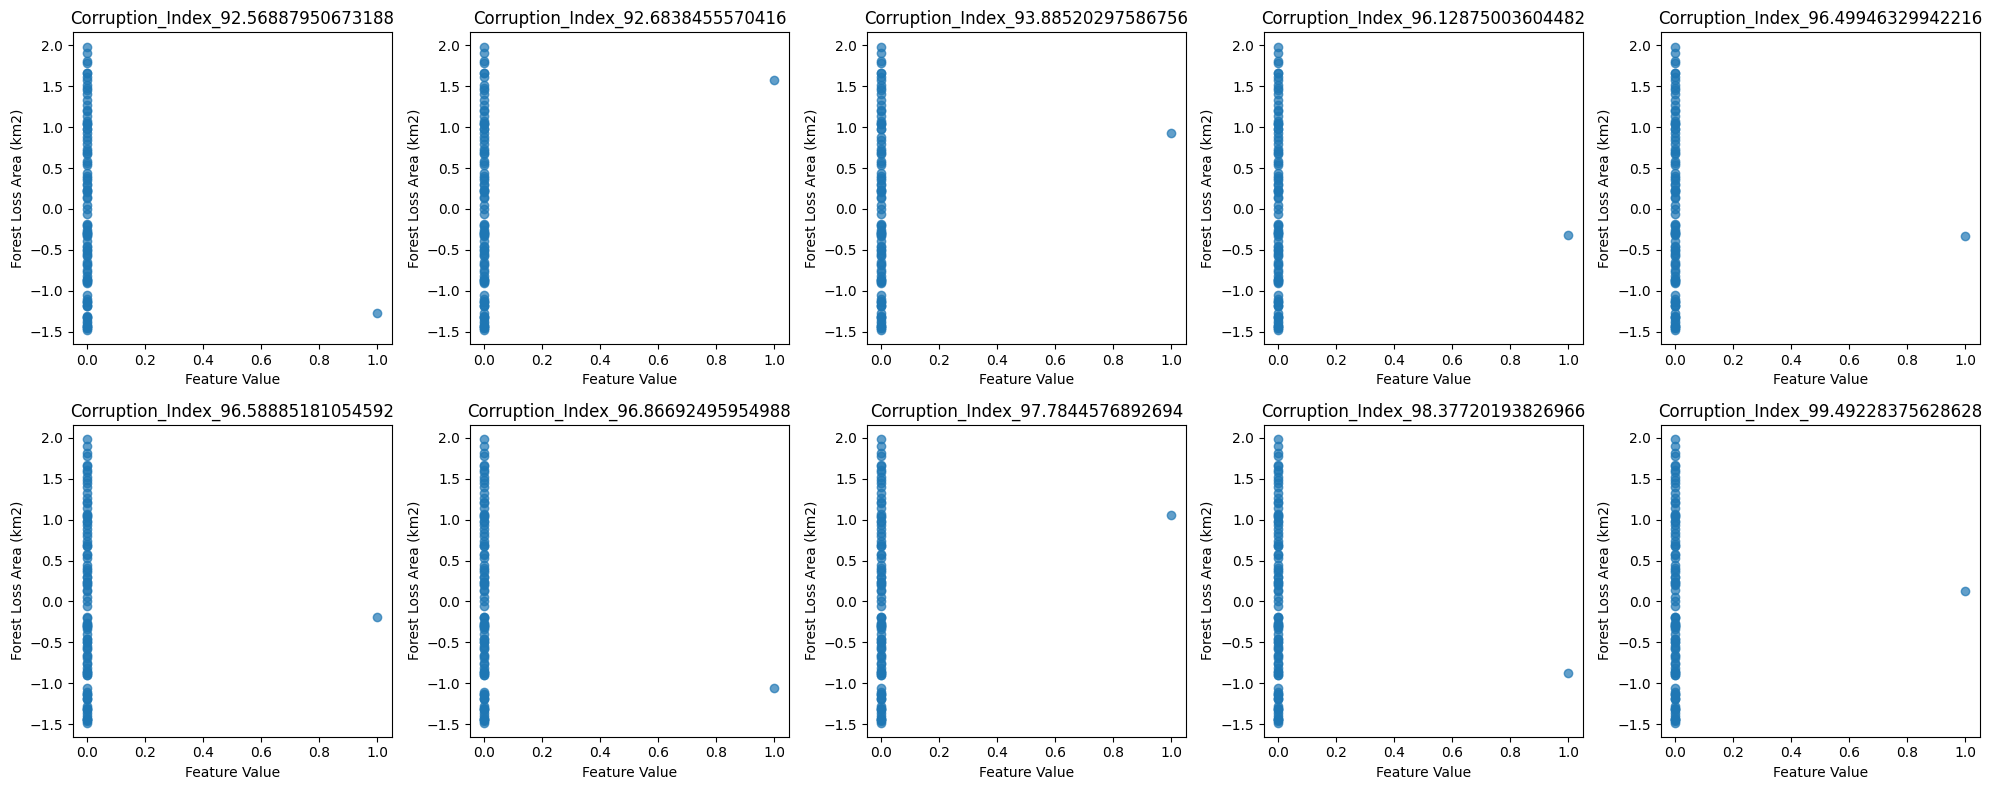

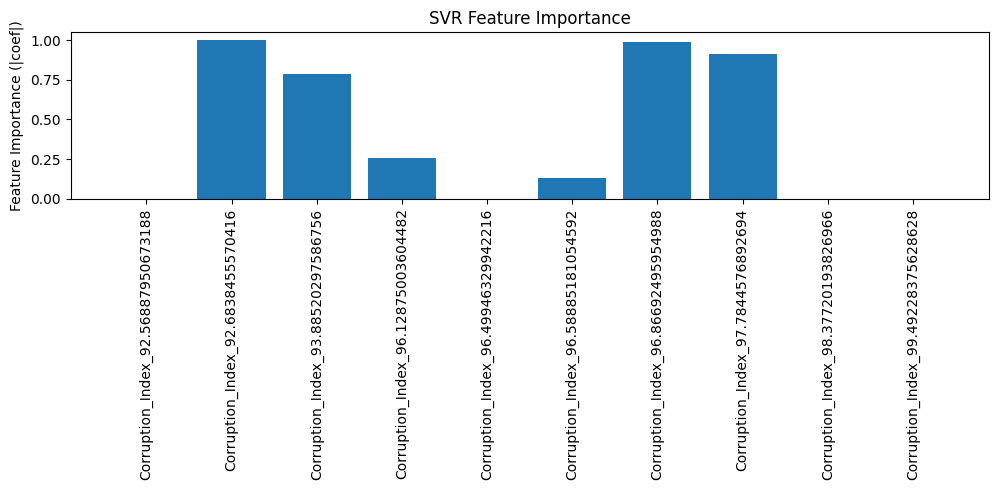

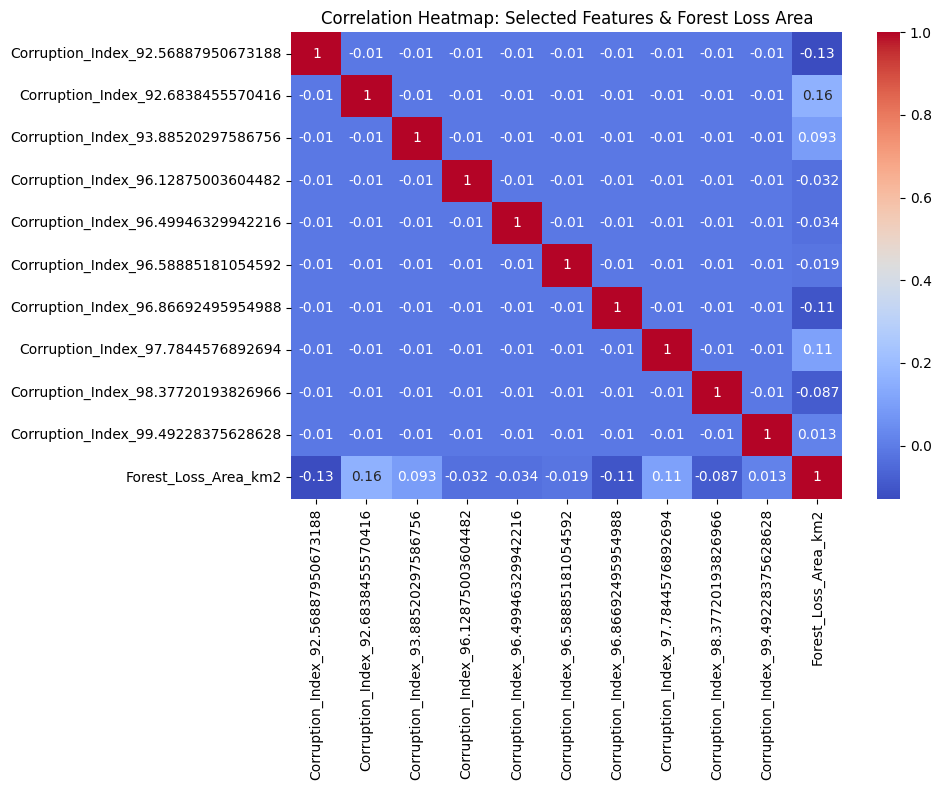

In [11]:
import seaborn as sns

import matplotlib.pyplot as plt

# Scatter plot: Each selected feature vs. Forest_Loss_Area_km2
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for idx, feature in enumerate(selected_features):
    ax = axes[idx // 5, idx % 5]
    # Get feature values from df_encoded
    feature_values = df_encoded[feature]
    ax.scatter(feature_values, df_encoded['Forest_Loss_Area_km2'], alpha=0.7)
    ax.set_title(feature)
    ax.set_xlabel('Feature Value')
    ax.set_ylabel('Forest Loss Area (km2)')
plt.tight_layout()
plt.show()

# Bar chart: Feature importance
plt.figure(figsize=(10, 5))
plt.bar(selected_features, feature_importance)
plt.xticks(rotation=90)
plt.ylabel("Feature Importance (|coef|)")
plt.title("SVR Feature Importance")
plt.tight_layout()
plt.show()

# Heatmap: Correlation between selected features and Forest_Loss_Area_km2
corr_matrix = df_encoded[list(selected_features) + ['Forest_Loss_Area_km2']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap: Selected Features & Forest Loss Area")
plt.tight_layout()
plt.show()

In [15]:
def generate_report():
    print("Comprehensive Report: Deforestation Drivers and Mitigation Strategies\n")

    print("1. Model Findings and Feature Influence:")
    print("--------------------------------------------------")
    print("The SVR model was trained to predict forest loss area using a variety of features, including population, economic indicators (GDP, international aid), policy strictness, and corruption index.")
    print("Feature selection identified the top contributors to deforestation prediction. In this dataset, encoded corruption index categories dominated the top 10 features, indicating corruption levels are the most influential variable in the current model.")
    print("Other variables such as population, GDP, and policy strictness were not selected among the top features, suggesting their direct influence on forest loss is less pronounced in this analysis. However, this may be due to the feature selection process or the encoding of categorical variables.\n")

    print("2. Influence of Key Variables:")
    print("--------------------------------------------------")
    print("- Population: Although not among the top selected features, population growth can increase pressure on forests due to land conversion for agriculture, urbanization, and resource extraction. Regions with rapidly growing populations may face higher deforestation risks.")
    print("- Economic Factors (GDP, International Aid): Higher GDP can provide resources for better forest management and enforcement, but may also drive economic activities (e.g., agriculture, logging) that increase deforestation. International aid, if targeted effectively, can support conservation efforts and sustainable development.")
    print("- Policy Strictness: Stricter deforestation policies are expected to reduce forest loss. However, the effectiveness of these policies is often undermined by high corruption levels, as indicated by the model's feature importance. Transparent governance and strong enforcement are critical for policy success.\n")

    print("3. Regional/Country-Level Mitigation Opportunities:")
    print("--------------------------------------------------")
    print("Based on the dataset, countries or regions with high corruption index values are most at risk for ineffective policy enforcement and higher deforestation rates. Targeted interventions in these areas should focus on:")
    print("- Strengthening governance and reducing corruption to improve policy enforcement.")
    print("- Enhancing transparency and accountability in forest management.")
    print("- Supporting community-based forest monitoring and reporting.")
    print("- Increasing international aid and technical support for anti-corruption initiatives.")
    print("Countries with moderate population growth and economic development may benefit from integrating sustainable land use planning and promoting alternative livelihoods to reduce pressure on forests.\n")

    print("4. Recommendations for Mitigation:")
    print("--------------------------------------------------")
    print("- Prioritize anti-corruption measures in forest governance, especially in countries where corruption index features are highly influential.")
    print("- Invest in capacity building for law enforcement and forest management agencies.")
    print("- Promote public awareness and stakeholder engagement to support policy compliance.")
    print("- Encourage international collaboration and funding for sustainable forest management and conservation projects.")
    print("- Consider further analysis with different models or feature engineering to uncover the roles of population, GDP, and policy strictness, as their indirect effects may be significant.\n")

    print("5. Limitations and Further Work:")
    print("--------------------------------------------------")
    print("- The current model's feature selection may have excluded some important variables due to encoding or statistical criteria. Future work should explore alternative feature selection methods and model types.")
    print("- Data quality, completeness, and representativeness can affect findings. Expanding the dataset and improving variable definitions may yield deeper insights.")
    print("- Regional context matters: interventions should be tailored to local socio-economic and governance conditions.\n")

    print("Summary:")
    print("--------------------------------------------------")
    print("Deforestation is a complex issue influenced by governance, economic, demographic, and policy factors. In this analysis, corruption emerged as the most critical driver, highlighting the need for robust governance reforms. Population and economic factors remain important and should be considered in broader policy frameworks. Effective mitigation requires multi-faceted, context-specific strategies combining policy, enforcement, community engagement, and international support.")

# Call the function to generate the report
generate_report()


Comprehensive Report: Deforestation Drivers and Mitigation Strategies

1. Model Findings and Feature Influence:
--------------------------------------------------
The SVR model was trained to predict forest loss area using a variety of features, including population, economic indicators (GDP, international aid), policy strictness, and corruption index.
Feature selection identified the top contributors to deforestation prediction. In this dataset, encoded corruption index categories dominated the top 10 features, indicating corruption levels are the most influential variable in the current model.
Other variables such as population, GDP, and policy strictness were not selected among the top features, suggesting their direct influence on forest loss is less pronounced in this analysis. However, this may be due to the feature selection process or the encoding of categorical variables.

2. Influence of Key Variables:
--------------------------------------------------
- Population: Although 

In [16]:

    print("Recommendations for Deforestation Mitigation\n")
    print("1. Strengthen Governance and Reduce Corruption:")
    print("- Implement transparent forest management systems and anti-corruption measures.")
    print("- Increase accountability and oversight in enforcement of deforestation policies.")
    print("- Support community-based monitoring and reporting to reduce illegal activities.")

    print("\n2. Enhance Policy Effectiveness:")
    print("- Enforce stricter deforestation policies and ensure compliance through regular audits.")
    print("- Integrate anti-corruption strategies into environmental regulations.")
    print("- Foster collaboration between government, NGOs, and local communities.")

    print("\n3. Promote Sustainable Economic Development:")
    print("- Encourage sustainable agriculture and forestry practices to reduce pressure on forests.")
    print("- Provide incentives for businesses adopting eco-friendly methods.")
    print("- Support alternative livelihoods for communities dependent on forest resources.")

    print("\n4. Increase International Aid and Technical Support:")
    print("- Target aid towards capacity building, technology transfer, and anti-corruption initiatives.")
    print("- Facilitate knowledge sharing and best practices across countries.")

    print("\n5. Raise Public Awareness and Stakeholder Engagement:")
    print("- Launch educational campaigns on the importance of forests and consequences of deforestation.")
    print("- Involve local stakeholders in decision-making and benefit-sharing.")

    print("\n6. Integrate Environmental Considerations:")
    print("- Expand protected areas and improve their management.")
    print("- Promote reforestation and restoration projects.")
    print("- Monitor environmental impacts and adapt policies as needed.")

    print("\nSummary:")
    print("A multi-faceted approach combining governance reforms, policy enforcement, sustainable economic incentives, community engagement, and international cooperation is essential for effective deforestation mitigation.")



Recommendations for Deforestation Mitigation

1. Strengthen Governance and Reduce Corruption:
- Implement transparent forest management systems and anti-corruption measures.
- Increase accountability and oversight in enforcement of deforestation policies.
- Support community-based monitoring and reporting to reduce illegal activities.

2. Enhance Policy Effectiveness:
- Enforce stricter deforestation policies and ensure compliance through regular audits.
- Integrate anti-corruption strategies into environmental regulations.
- Foster collaboration between government, NGOs, and local communities.

3. Promote Sustainable Economic Development:
- Encourage sustainable agriculture and forestry practices to reduce pressure on forests.
- Provide incentives for businesses adopting eco-friendly methods.
- Support alternative livelihoods for communities dependent on forest resources.

4. Increase International Aid and Technical Support:
- Target aid towards capacity building, technology transfer,